### RQ3


In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats
import os

# Load the labeled data with SATD categories
# Assuming we have a CSV file with the 50 manually classified methods
df = pd.read_csv('final_annotated messages.csv', encoding='cp1252')


In [17]:
# Display basic information about the dataset
print(f"Total annotated methods: {len(df)}")

# Group by SATD category and count
satd_categories = df['Final annotation'].value_counts()
print("\nDistribution of SATD categories:")
print(satd_categories)

# Calculate average complexity metrics for each SATD category
category_complexity = df.groupby('Final annotation').agg({
    'complexity_before': 'mean',
    'complexity_after': 'mean',
    'complexity_change': 'mean',
    'satd_before_count': 'mean',
    'satd_after_count': 'mean'
}).round(2)

print("\nAverage metrics by SATD category:")
print(category_complexity)

Total annotated methods: 58

Distribution of SATD categories:
Final annotation
Defect Debt            10
Code Debt               9
Documentation Debt      8
Architecture Debt       6
Requirement Debt        4
Document Debt           2
Design Debt             2
Architeture Debt        2
Infrastructure Debt     1
Infrastrucre Debt       1
Desiign Debt            1
Infrastruture Debt      1
Test Debt               1
Documantation Debt      1
Name: count, dtype: int64

Average metrics by SATD category:
                     complexity_before  complexity_after  complexity_change  \
Final annotation                                                              
Architecture Debt                 7.33              8.00               0.67   
Architeture Debt                  1.50              1.50               0.00   
Code Debt                         3.78              3.44              -0.33   
Defect Debt                       5.50              6.60               1.10   
Design Debt           

In [19]:
# Qualitative analysis function
def analyze_category_examples(df, category):
    """Provides detailed analysis of examples from a specific SATD category"""
    category_examples = df[df['Final annotation'] == category]

    print(f"\n{'='*80}")
    print(f"Qualitative Analysis for {category} (n={len(category_examples)})")
    print(f"{'='*80}")

    # Overall statistics
    print(f"Average complexity before: {category_examples['complexity_before'].mean():.2f}")
    print(f"Average complexity after: {category_examples['complexity_after'].mean():.2f}")
    print(f"Average complexity change: {category_examples['complexity_change'].mean():.2f}")

    # Look at examples where complexity increased significantly
    high_increase = category_examples[category_examples['complexity_change'] > 3]
    if len(high_increase) > 0:
        print(f"\nSignificant complexity increases ({len(high_increase)}):")
        for _, row in high_increase.iterrows():
            print(f"  - Method: {row['method_name']} in {row['file_name']}")
            print(f"    Complexity: {row['complexity_before']} → {row['complexity_after']} (Δ{row['complexity_change']})")
            print(f"    Commit message: {row['commit_msg'][:100]}...")

    # Look at examples where complexity decreased significantly
    high_decrease = category_examples[category_examples['complexity_change'] < -3]
    if len(high_decrease) > 0:
        print(f"\nSignificant complexity decreases ({len(high_decrease)}):")
        for _, row in high_decrease.iterrows():
            print(f"  - Method: {row['method_name']} in {row['file_name']}")
            print(f"    Complexity: {row['complexity_before']} → {row['complexity_after']} (Δ{row['complexity_change']})")
            print(f"    Commit message: {row['commit_msg'][:100]}...")

    # Analyze any patterns in the commit messages
    print("\nCommon terms in commit messages:")
    all_msgs = ' '.join(category_examples['commit_msg'].fillna(''))
    words = all_msgs.lower().split()
    word_count = pd.Series(words).value_counts().head(10)
    print(word_count)

    return category_examples


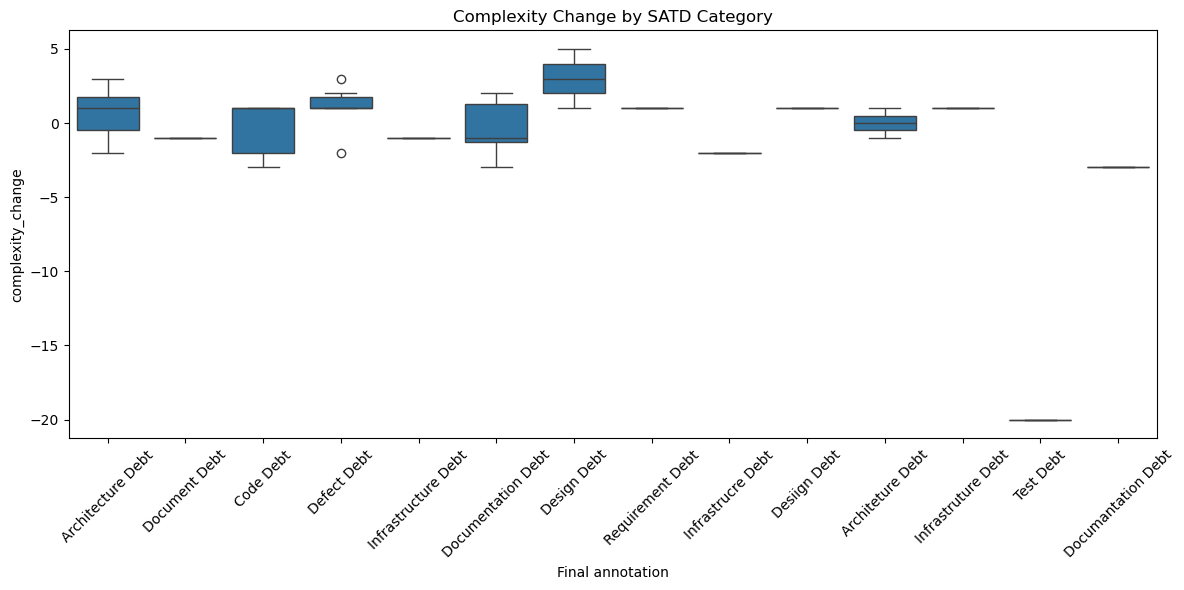

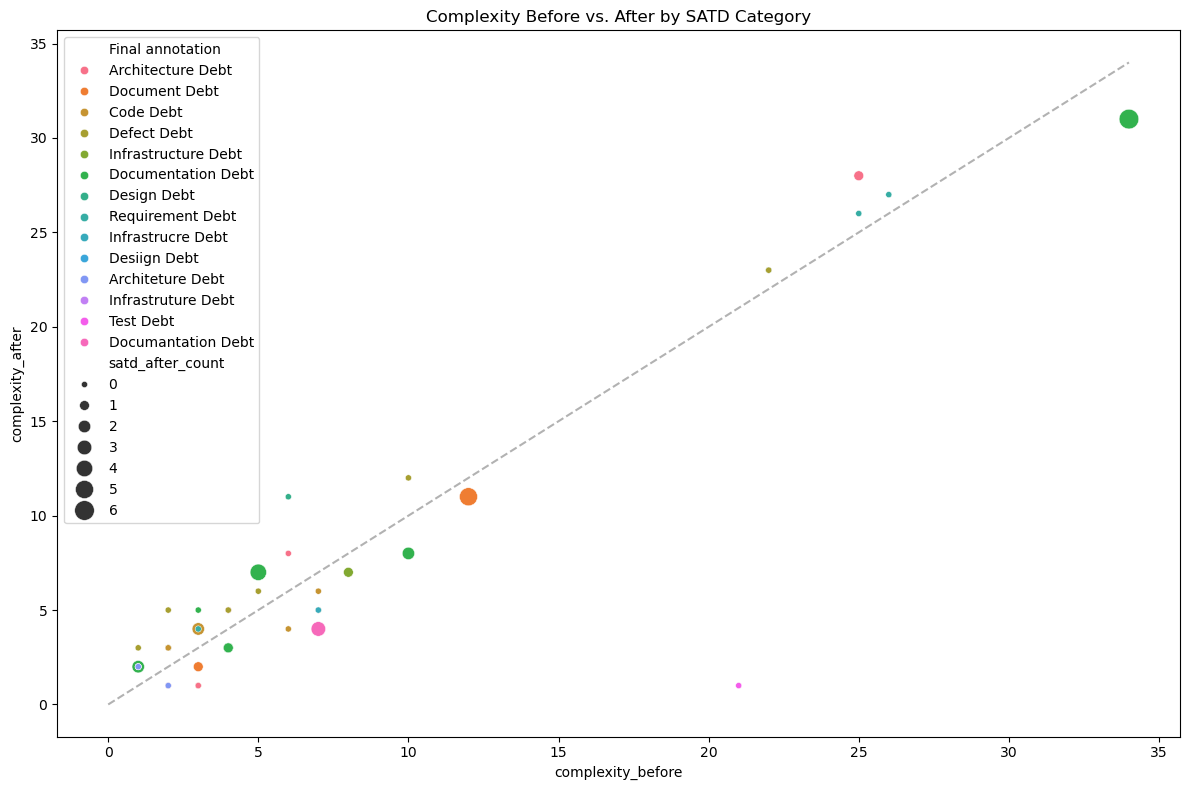

In [21]:
# Create a directory for visualizations if it doesn't exist
os.makedirs('visualizations', exist_ok=True)

# 1. Box plot of complexity changes by SATD category
plt.figure(figsize=(12, 6))
sns.boxplot(x='Final annotation', y='complexity_change', data=df)
plt.title('Complexity Change by SATD Category')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('visualizations/complexity_change_by_category.png')

# 2. Scatter plot of complexity before vs. after for each category
plt.figure(figsize=(12, 8))
sns.scatterplot(x='complexity_before', y='complexity_after',
                hue='Final annotation', size='satd_after_count',
                sizes=(20, 200), data=df)
plt.title('Complexity Before vs. After by SATD Category')
plt.plot([0, df['complexity_before'].max()], [0, df['complexity_before'].max()],
         'k--', alpha=0.3)  # Diagonal line where before = after
plt.tight_layout()
plt.show()

In [23]:
# Perform the qualitative analysis for each SATD category
unique_categories = df['Final annotation'].dropna().unique()

# Create a report file
with open('qualitative_analysis_report.txt', 'w') as f:
    f.write("QUALITATIVE ANALYSIS OF SATD CATEGORIES\n")
    f.write("======================================\n\n")

    f.write(f"Total annotated methods: {len(df)}\n\n")

    f.write("Distribution of SATD categories:\n")
    for category, count in satd_categories.items():
        f.write(f"- {category}: {count}\n")

    f.write("\nAverage metrics by SATD category:\n")
    f.write(f"{category_complexity.to_string()}\n\n")

    # Perform in-depth analysis of each category
    for category in unique_categories:
        category_df = analyze_category_examples(df, category)

        f.write(f"\n{'='*80}\n")
        f.write(f"DETAILED ANALYSIS: {category.upper()} (n={len(category_df)})\n")
        f.write(f"{'='*80}\n\n")

        # Write statistical summary
        f.write("Statistical Summary:\n")
        f.write(f"- Average complexity before: {category_df['complexity_before'].mean():.2f}\n")
        f.write(f"- Average complexity after: {category_df['complexity_after'].mean():.2f}\n")
        f.write(f"- Average complexity change: {category_df['complexity_change'].mean():.2f}\n")
        f.write(f"- Median complexity change: {category_df['complexity_change'].median():.2f}\n")
        f.write(f"- Range of complexity change: {category_df['complexity_change'].min():.2f} to {category_df['complexity_change'].max():.2f}\n\n")

        # Write representative examples
        f.write("Representative Examples:\n")
        # Sort by absolute complexity change to find most significant changes
        significant_examples = category_df.loc[category_df['complexity_change'].abs().nlargest(3).index]

        for i, (_, row) in enumerate(significant_examples.iterrows(), 1):
            f.write(f"Example {i}:\n")
            f.write(f"- Method: {row['method_name']} in {os.path.basename(str(row['file_name']))}\n")
            f.write(f"- Complexity: {row['complexity_before']} → {row['complexity_after']} (Δ{row['complexity_change']})\n")
            f.write(f"- SATD before: {row['satd_before_count']}, SATD after: {row['satd_after_count']}\n")
            f.write(f"- Commit message: {row['commit_msg'][:200]}...\n\n")

        # Thematic analysis - identify patterns
        f.write("Thematic Analysis:\n")
        # This would normally involve manual coding and pattern identification
        # Here we'll use a simple approach based on available metrics

        if category_df['complexity_change'].mean() > 0:
            f.write(f"- {category} tends to be associated with increased complexity.\n")
        else:
            f.write(f"- {category} tends to be associated with decreased or stable complexity.\n")

        if category_df['satd_change'].mean() > 0:
            f.write(f"- {category} is often associated with adding more SATD comments.\n")
        elif category_df['satd_change'].mean() < 0:
            f.write(f"- {category} is often associated with removing SATD comments.\n")
        else:
            f.write(f"- {category} doesn't show a clear pattern of SATD comment changes.\n")

        # This part would be based on manual review in a real qualitative analysis
        f.write("- Further thematic patterns would require detailed code review and context analysis.\n\n")


Qualitative Analysis for Architecture Debt (n=6)
Average complexity before: 7.33
Average complexity after: 8.00
Average complexity change: 0.67

Common terms in commit messages:
ttl                38
*                  34
and                28
to                 25
for                22
co-authored-by:    20
column             20
in                 16
views              16
add                13
Name: count, dtype: int64


UnicodeEncodeError: 'charmap' codec can't encode character '\u2192' in position 19: character maps to <undefined>

In [25]:
print("\nQualitative analysis completed! Check 'qualitative_analysis_report.txt' for detailed findings.")

# Optional: Perform some statistical tests to supplement qualitative analysis
if len(unique_categories) > 1:
    print("\nSupplementary Statistical Tests:")
    # Check if categories have significantly different complexity changes
    from scipy.stats import kruskal

    # Non-parametric Kruskal-Wallis test (doesn't assume normal distribution)
    category_groups = [df[df['Final annotation'] == cat]['complexity_change'].dropna()
                      for cat in unique_categories if len(df[df['Final annotation'] == cat]) > 0]

    if all(len(group) > 0 for group in category_groups):
        stat, p_value = kruskal(*category_groups)
        print(f"Kruskal-Wallis test for differences in complexity change between SATD categories:")
        print(f"H-statistic: {stat:.2f}, p-value: {p_value:.4f}")

        if p_value < 0.05:
            print("There are statistically significant differences in complexity change between SATD categories.")
        else:
            print("No statistically significant differences in complexity change between SATD categories.")


Qualitative analysis completed! Check 'qualitative_analysis_report.txt' for detailed findings.

Supplementary Statistical Tests:
Kruskal-Wallis test for differences in complexity change between SATD categories:
H-statistic: 17.58, p-value: 0.1740
No statistically significant differences in complexity change between SATD categories.
